# `02-preprocessing`
In this notebook, we showcase the pre-processing steps

## Preliminaries
Imports

In [1]:
import pathlib
import wfdb
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 600

import src.signals.rr as rr
import src.signals.nn as nn
import src.signals.respiration as resp

Define paths (based on the Cookiecutter file structure)

In [2]:
PATH_DATA = pathlib.Path('../data')

## Peek into the data
We will take a quick look at how some of the signals look like.
For now, we will only take a look at 10,000 samples.

In [3]:
sample_from = 0
sample_to = 10_000

We can read a record with [`wfdb.rdrecord`](https://wfdb.readthedocs.io/en/latest/wfdb.html#wfdb.rdrecord),
annotations with [`wfdb.rdann`](https://wfdb.readthedocs.io/en/latest/wfdb.html#wfdb.rdann)
and easily plot them with [`wfdb.plot_wfdb`](https://wfdb.readthedocs.io/en/latest/wfdb.html#wfdb.plot_wfdb).
Notice how we some matplotlib for tweaking the plot.

Notice how in this case, the annotations correspond to the R peaks marked
on top of the respiration signal.

{'record_name': 'f1y01', 'n_sig': 2, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 10000, 'base_time': None, 'base_date': None, 'comments': ['Age: 23 Sex: F'], 'sig_name': ['RESP', 'ECG'], 'p_signal': array([[8.   , 7.952],
       [8.044, 7.936],
       [8.   , 8.004],
       ...,
       [8.784, 7.896],
       [8.708, 7.784],
       [8.76 , 7.872]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['f1y01.dat', 'f1y01.dat'], 'fmt': ['16', '16'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [2000.0, 2000.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [16, 16], 'adc_zero': [0, 0], 'init_value': [16000, 15904], 'checksum': [30624, 1544], 'block_size': [0, 0]}


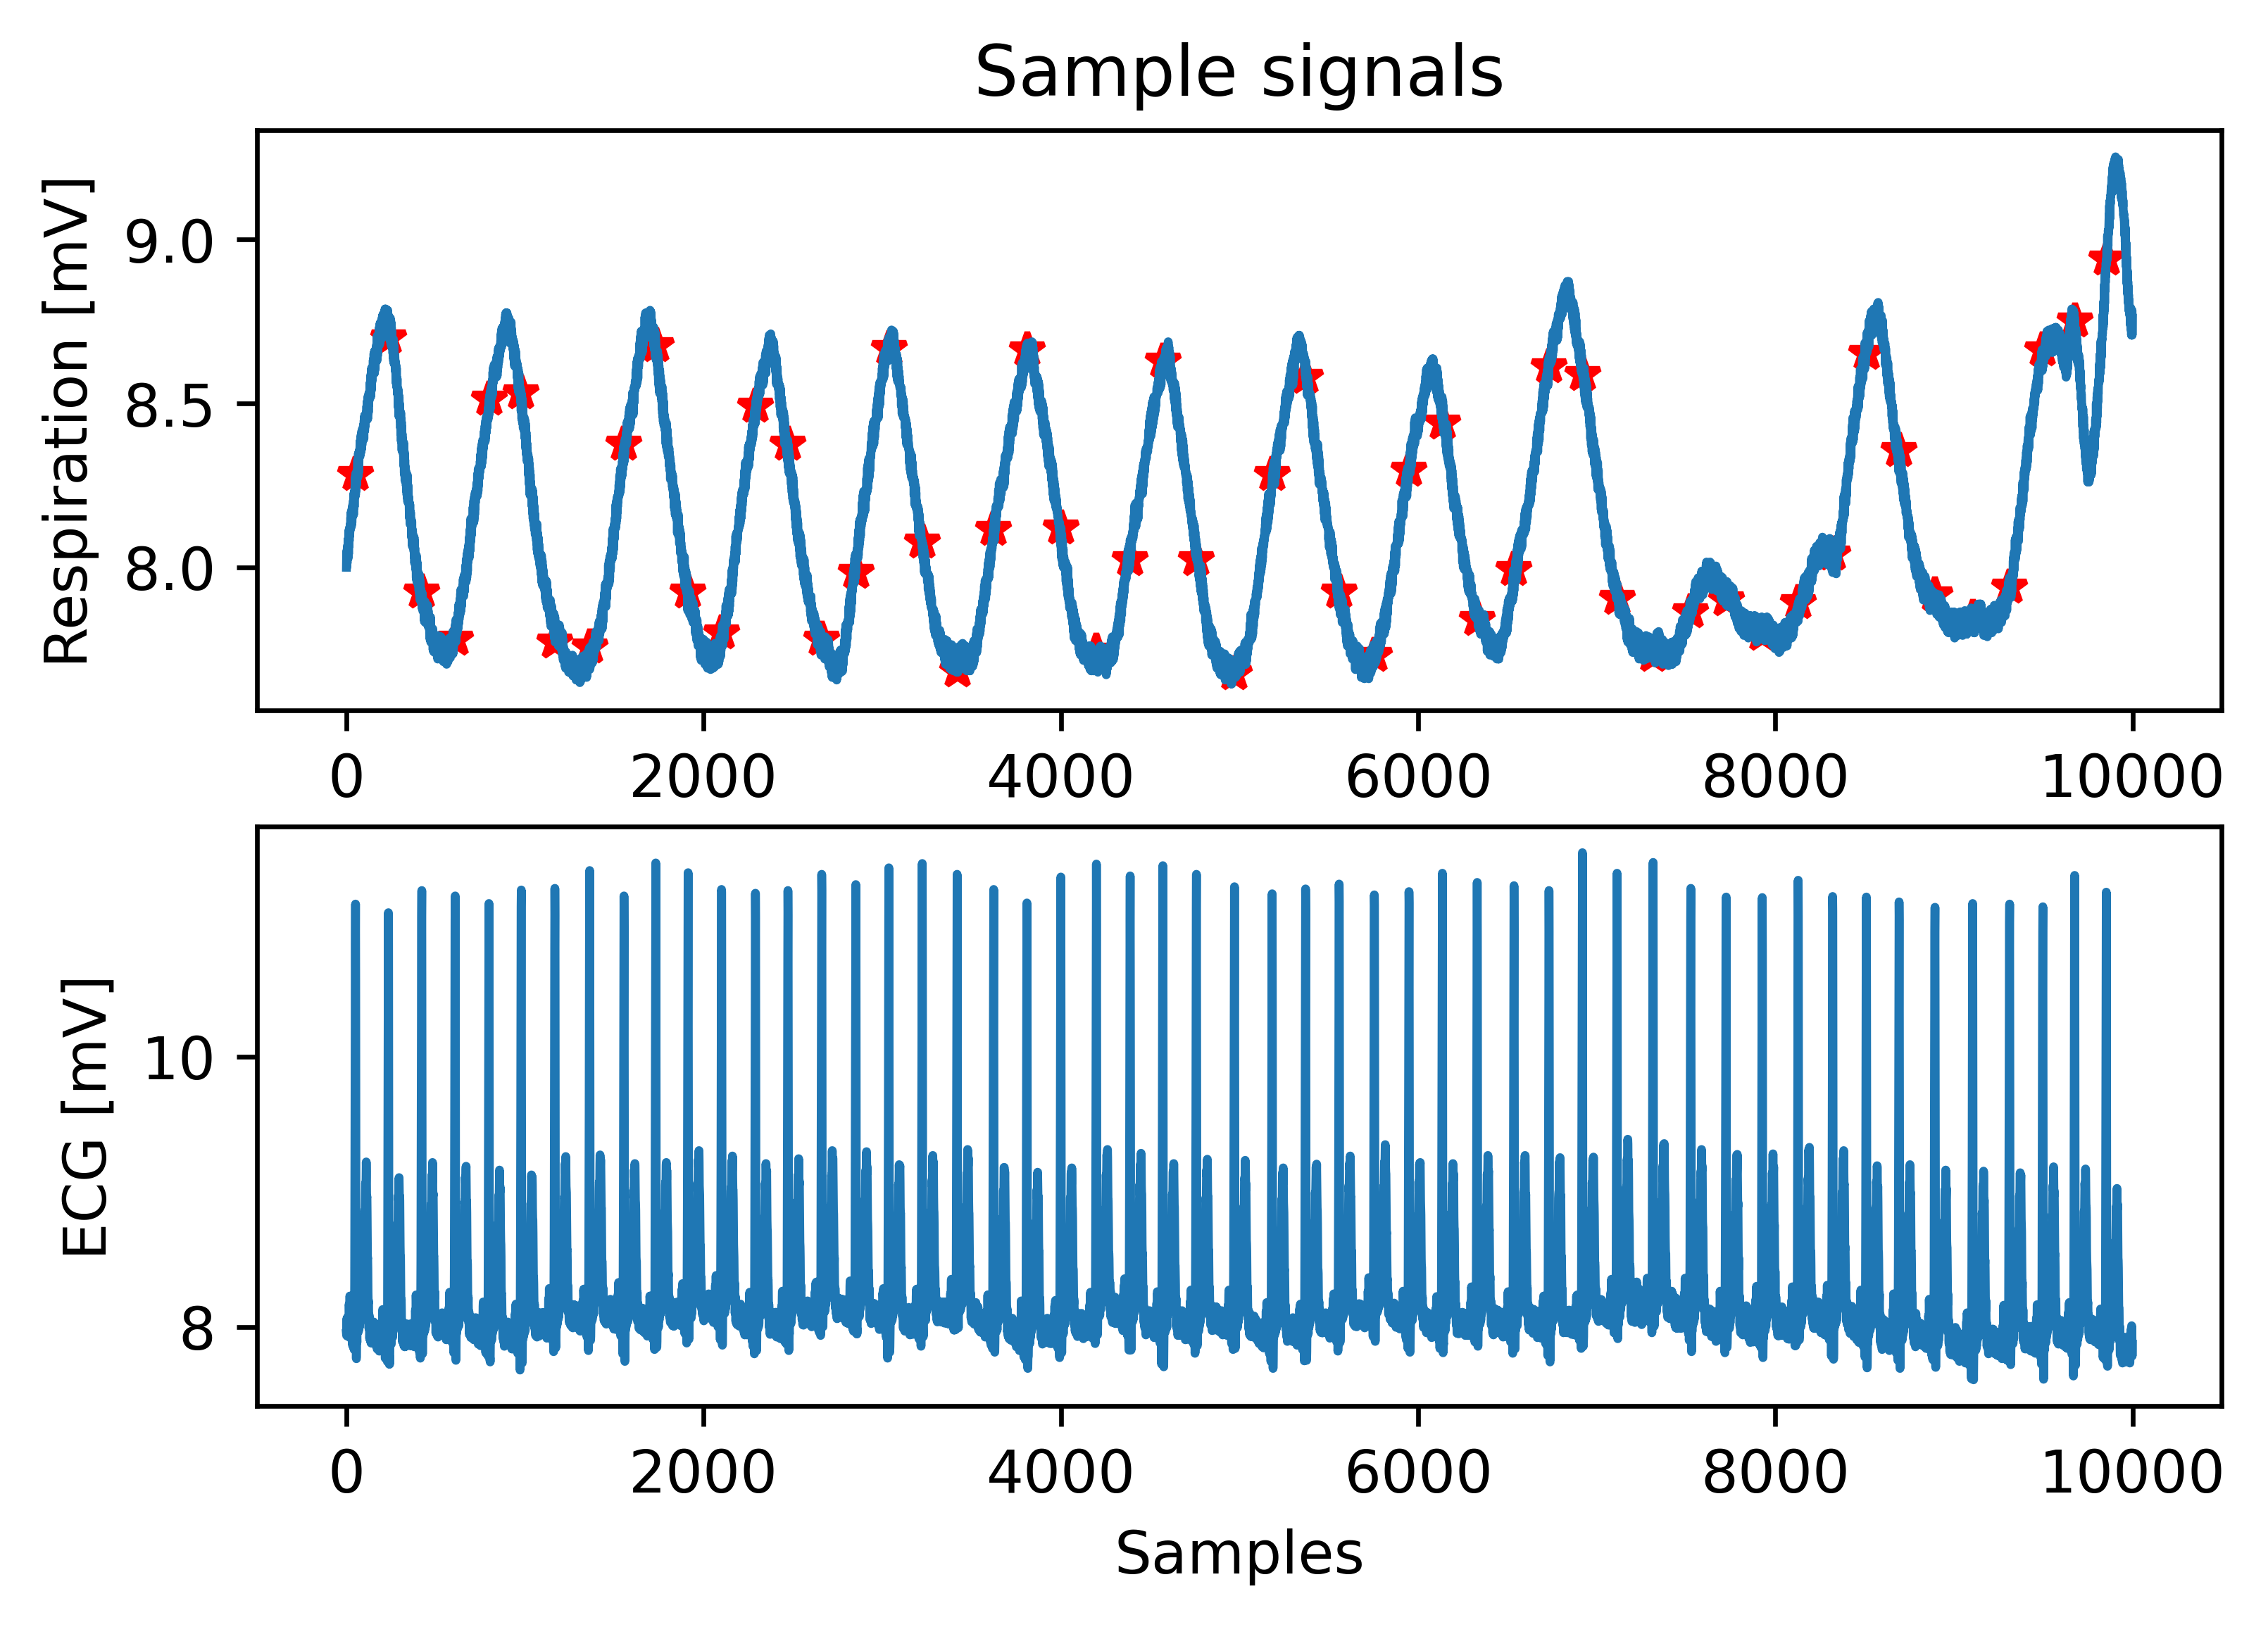

In [4]:
participant = 'f1y01'
record = wfdb.rdrecord(str(PATH_DATA/'raw'/participant), sampfrom=sample_from, sampto=sample_to)
annotation = wfdb.rdann(str(PATH_DATA/'raw'/participant), 'ecg', sampfrom=sample_from, sampto=sample_to)

fig = wfdb.plot_wfdb(record=record, title='Sample signals', annotation=annotation, return_fig=True) 
ax = fig.axes
ax[1].set_xlabel("Samples")

ax[0].set_ylabel("Respiration [mV]")
ax[1].set_ylabel("ECG [mV]")

print(record.__dict__)

A couple of important variables for further use.

In [5]:
fs = record.fs # Sampling rate
Ts = 1/fs # Sampling period
n_samples = record.sig_len # Total number of samples
t = np.arange(0, n_samples*Ts, Ts)

In this case, the annotations correspond to the R peaks of the ECG marked
on top of the respiration signal.

We can also take a peek into the annotations. 
A complete description of what the annotations mean can be found [here](https://github.com/MIT-LCP/wfdb-python/blob/0d42dfb4b2946625f00cbf500d830d374a201153/wfdb/io/annotation.py#L14)

In [6]:
annotations = annotation.symbol
r_peaks_samples = annotation.sample

print(annotations[0:10])
print(r_peaks_samples[0:10])
print(set(annotations))

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
[  52  236  422  610  799  979 1168 1363 1555 1733]
{'N'}


## Pre-processing
### Compute NN intervals

In [7]:
r_peaks_t = r_peaks_samples * Ts # [samples] --> [s]
nn_x, nn_y = rr.calculate_nn(r_peaks_t)

### Interpolate NN intervals

In [8]:
T_int = 0.2 # Interpolation interval [s]
last_time_sample = n_samples * Ts
nn_interp_x, nn_interp_y = nn.interpolate(nn_x, nn_y, from_time=0, to_time=last_time_sample, T_int=T_int)

### Smooth respiration signal

In [9]:
respiration = record.p_signal[:,0]
respiration_smooth_x, respiration_smooth_y = resp.smooth(respiration, nn_interp_x, from_time=0, to_time=last_time_sample, Ts=Ts, T_int=T_int)

## Visualizations
These are similar to Fig. 1b, 1c, and 1d of the original paper.

Text(0, 0.5, 'Respiration [mV]')

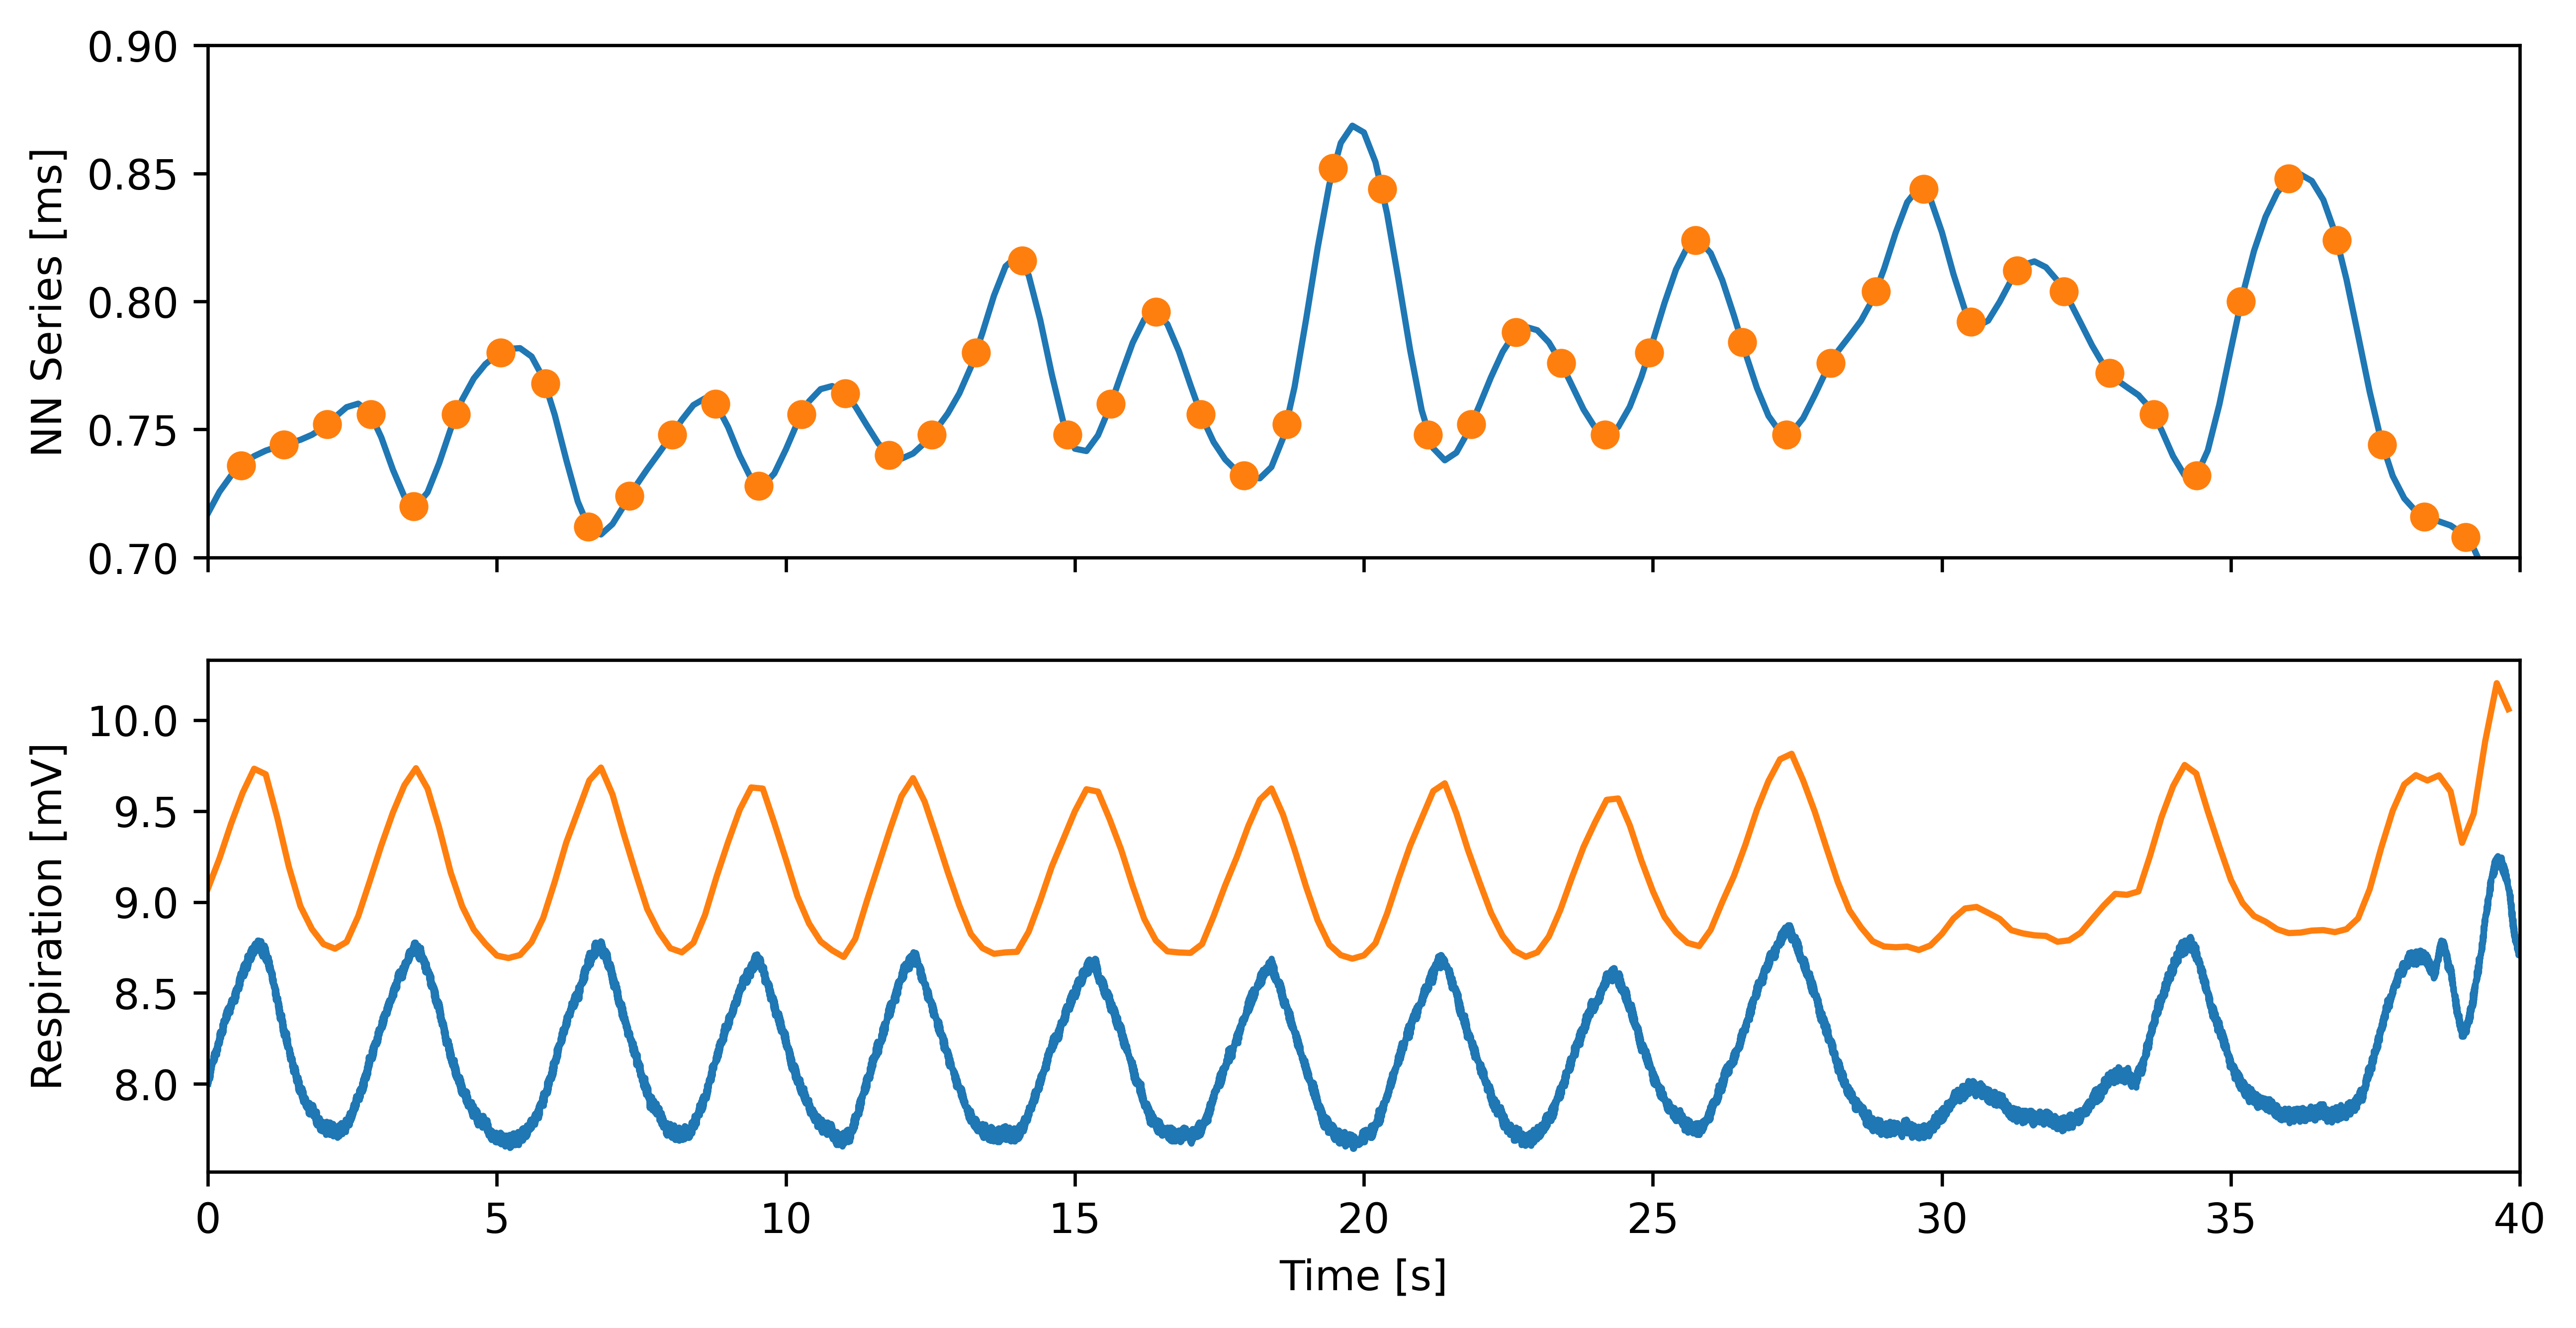

In [10]:
fig, ax = plt.subplots(2, 1, figsize=[10,5], sharex=True)
ax[0].plot(nn_interp_x, nn_interp_y)
ax[0].plot(nn_x, nn_y, marker='o', linestyle='None')
ax[0].set_ylim([0.7, 0.9])
ax[0].set_ylabel("NN series [ms]")

ax[1].plot(t, respiration)
ax[1].plot(respiration_smooth_x, respiration_smooth_y+1)
ax[1].set_xlim([0, 40])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Respiration [mV]")

The top panel shows the NN series. The dots correspond to the original
points, while the line corresponds to the interpolated signal.

The bottom panel shows the respiration signals. In blue, the original
(noisy) signal, in orange the smoothened signal (shifted upwards artificially
for clarity). 

Notice how "the minima of the NN curve generally occur near the inspirational 
maxima of breathing activity and *vice versa*".

The rest of the pre-processing consists in splitting the original
signals into parts of 5 min length, which isn't particularly interesting
to showcase in this notebook.